# Robustness Analysis: Adjoint and Toggle-Frame Objectives Subject to Either Multiplicative or Additive Errors

This notebook compares the performance of the adjoint and toggling-frame robustness objectives for multiplicative and additive error terms in the system's Hamiltonian. 

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
# Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using Random
using NamedTrajectories


  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryUniversalProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryUniversalProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243


In [2]:
# Problem parameters
T = 30
Δt = 0.2
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)

QuantumSystem: levels = 2, n_drives = 3

sanity checks for our good ole adjoint

In [3]:
sys.H.H_drives

3-element Vector{SparseMatrixCSC{ComplexF64, Int64}}:
 sparse([2, 1], [1, 2], ComplexF64[1.0 + 0.0im, 1.0 + 0.0im], 2, 2)
 sparse([2, 1], [1, 2], ComplexF64[0.0 + 1.0im, 0.0 - 1.0im], 2, 2)
 sparse([1, 2], [1, 2], ComplexF64[1.0 + 0.0im, -1.0 + 0.0im], 2, 2)

In [4]:
typeof(sys.H)

PiccoloQuantumObjects.QuantumSystems.var"#6#15"{SparseMatrixCSC{ComplexF64, Int64}, Vector{SparseMatrixCSC{ComplexF64, Int64}}}

In [5]:
length(sys.H.H_drives)
X_drive = sys.H.H_drives[1]
X_drive === H_drive[1]

false

In [6]:
Random.seed!(5)

#Adjoint
∂ₑHₐ = PAULIS.X
varsys_add = VariationalQuantumSystem(
    H_drive,
    [PAULIS.X, PAULIS.Y, PAULIS.Z]
)



ftog_prob = UnitaryToggleProblem(
    varsys_add, U_goal, T, Δt;
                    a_bound=4.0,
                    dda_bound=2.0,
                    Δt_max=Δt,
                    Δt_min=Δt,
                    piccolo_options=piccolo_opts,
                    Q_t=1.0
                )

solve!(ftog_prob, max_iter=200, print_level=5)


var_prob = UnitaryVariationalProblem(
        varsys_add, U_goal, T, Δt;
        robust_times=[[T], [T], [T]],
        a_bound=4.0,
        Δt_max=Δt,
        Δt_min=Δt,
        dda_bound = 2.0,
        piccolo_options=piccolo_opts
    )

solve!(var_prob, max_iter=200, print_level=5)

#Default
def = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; Q_t=1.0)
# solve!(def, max_iter=500, print_level=1, options=IpoptOptions(eval_hessian=false))
solve!(def, max_iter=150, print_level=5)
 

    initializing optimizer...
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:     3212
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    46318

Total n

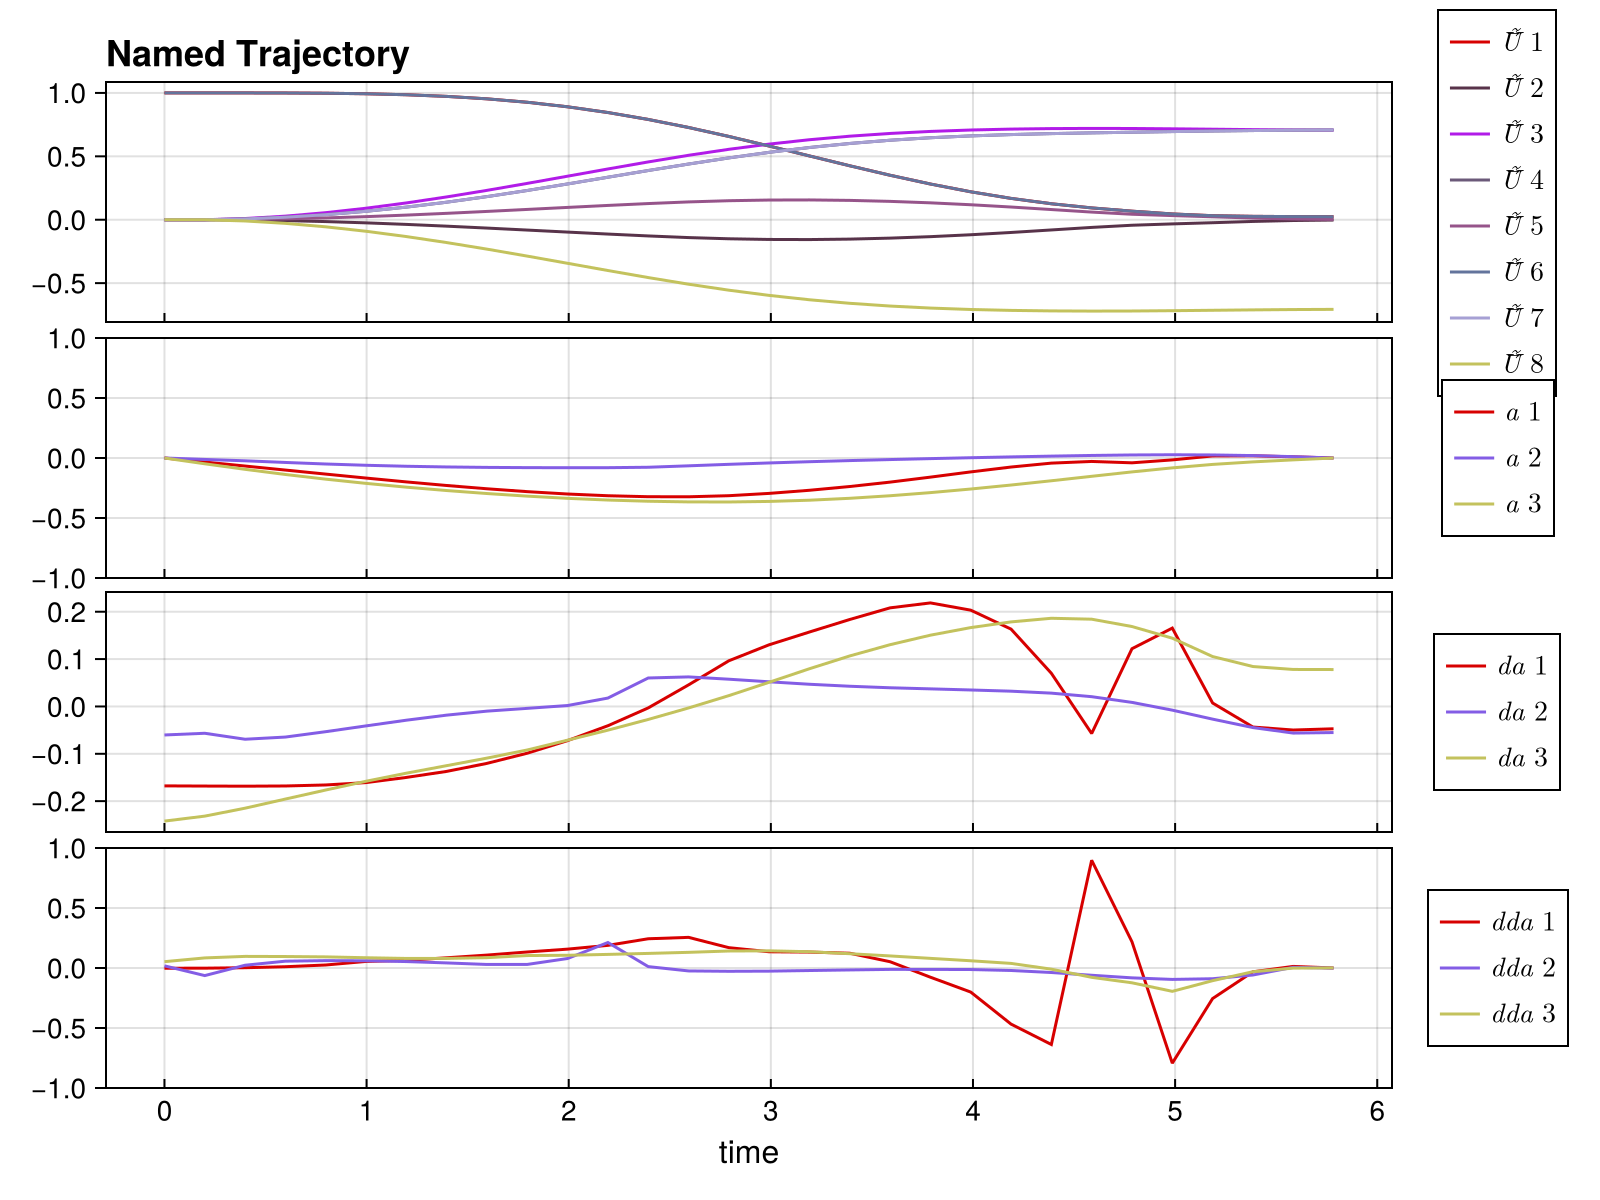

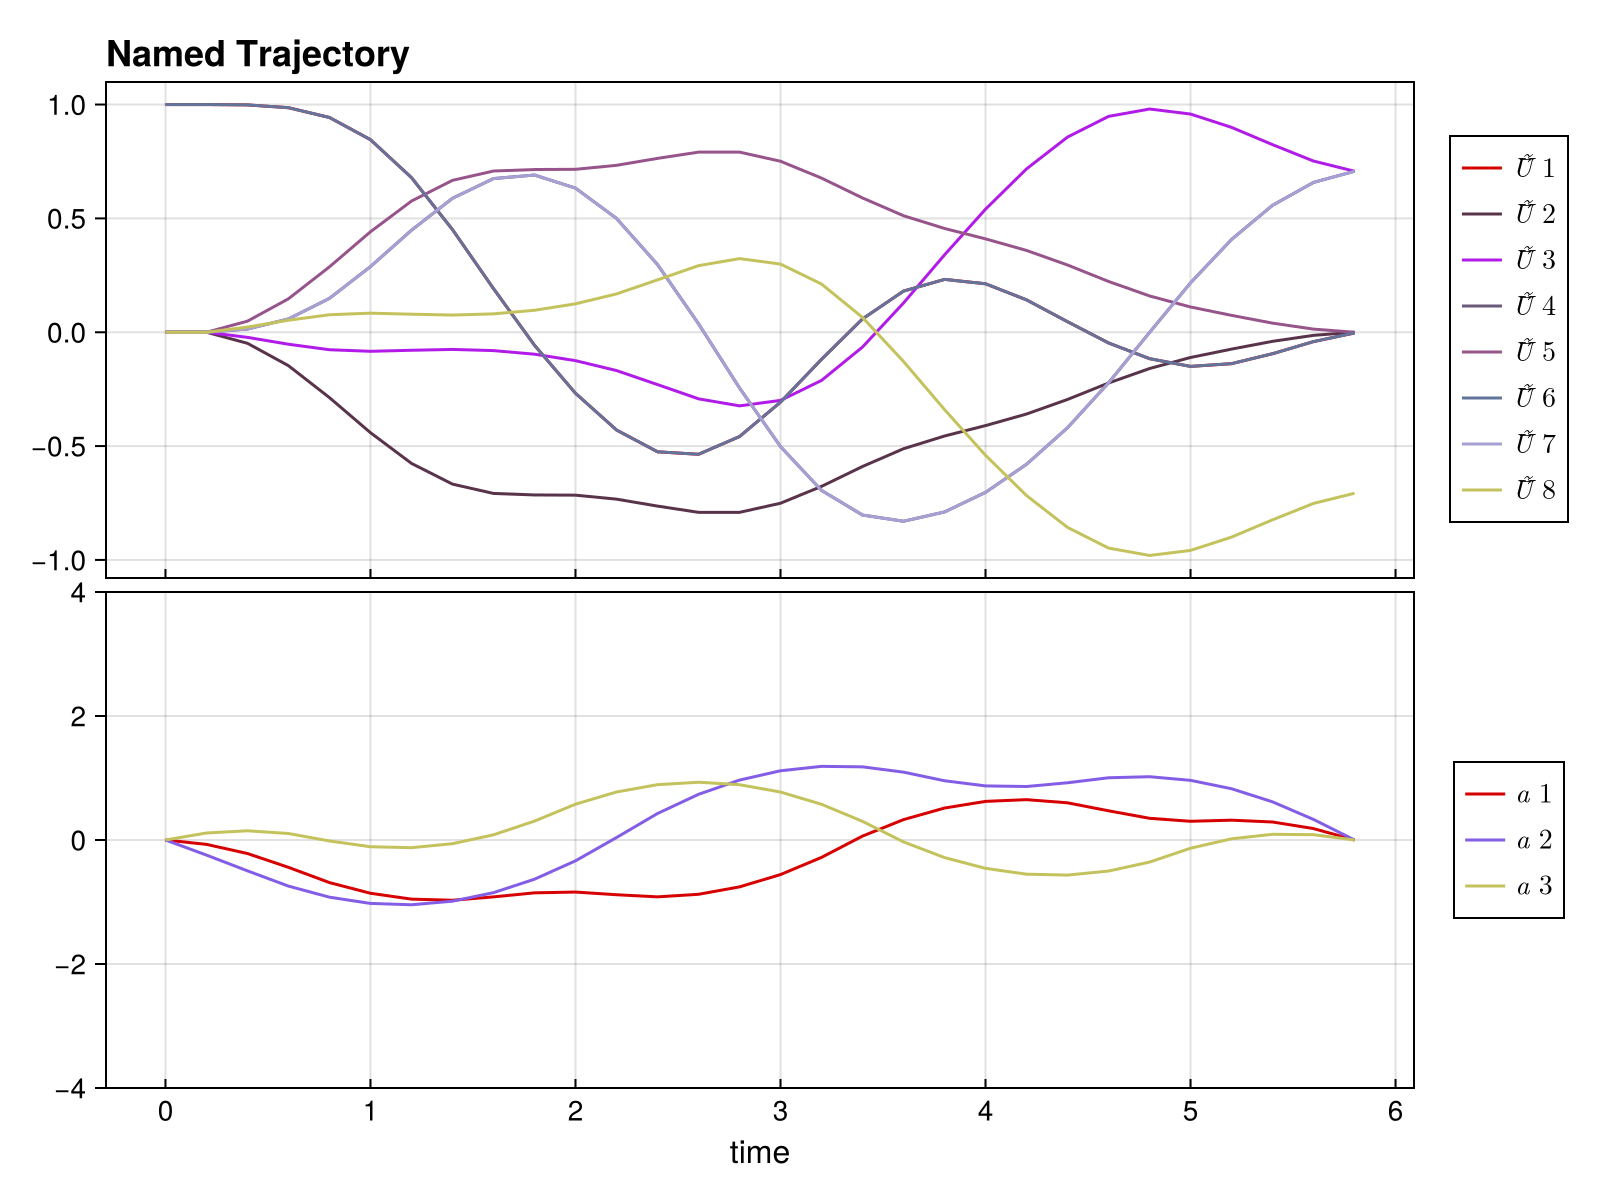

UndefVarError: UndefVarError: `tog_prob` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [7]:
display(CairoMakie.plot(def.trajectory, [:Ũ⃗, :a, :da, :dda]))
display(CairoMakie.plot(var_prob.trajectory, [:Ũ⃗, :a]))
display(CairoMakie.plot(tog_prob.trajectory, [:Ũ⃗, :a]))
display(CairoMakie.plot(ftog_prob.trajectory, [:Ũ⃗, :a]))

In [8]:
var_prob.trajectory.Δt[1], var_prob.trajectory.Δt[end ÷ 2]

(0.2, 0.2)

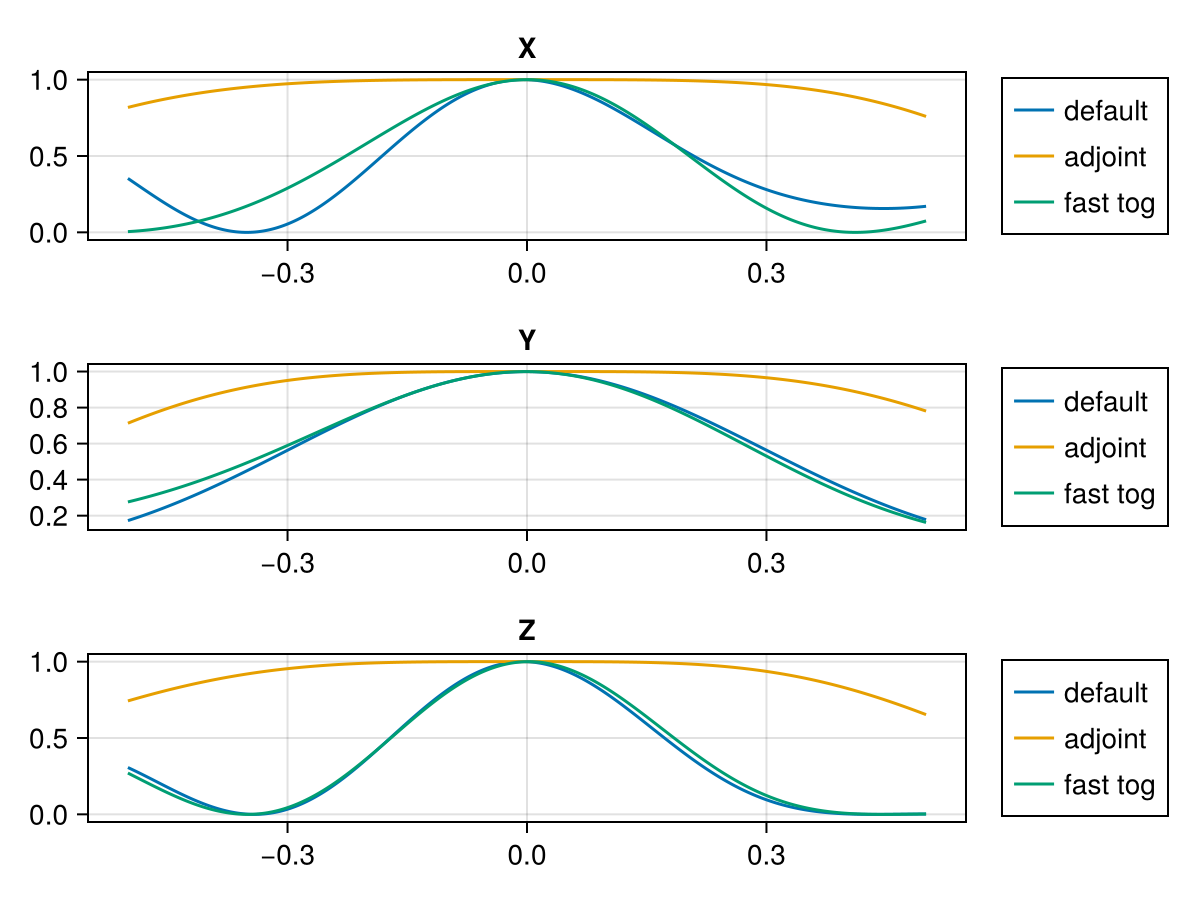

In [9]:
H_drive_add = H_drive

f = Figure()
axX = Axis(f[1, 1], title = "X")
axY = Axis(f[2, 1], title = "Y")
axZ = Axis(f[3, 1], title = "Z")

colors = Makie.wong_colors()
εs = -0.5:0.001:0.5

basis = [PAULIS.X, PAULIS.Y, PAULIS.Z]

axes_paulis = [
    (axX, PAULIS.X),
    (axY, PAULIS.Y),
    (axZ, PAULIS.Z),
]

problems = [
    (def,        "default"),
    (var_prob, "adjoint"),
    (ftog_prob, "fast tog"),
]

# Helper to compute the curve once per (problem, Pauli)
fidelity_curve(prob, pauli) = [unitary_rollout_fidelity(prob.trajectory, QuantumSystem(ε * pauli, basis)) for ε in εs]

# Plot everything with two compact loops
for (ax, pauli) in axes_paulis
    for (i, (prob, label)) in enumerate(problems)
        ys = fidelity_curve(prob, pauli)
        lines!(ax, εs, ys; label = label, color = colors[i], linestyle = :solid)
    end
end

Legend(f[1, 2], axX, position = :lb)
Legend(f[2, 2], axY, position = :lb)
Legend(f[3, 2], axZ, position = :lb)

f


# Verify first-order robustness with space curve approach

In [10]:
var_prob.trajectory
ftog_prob.trajectory

T = 30, (Ũ⃗ = 1:8, a = 9:11, da = 12:14, dda = 15:17, → Δt = 18:18)

In [11]:
using NamedTrajectories

var_traj = var_prob.trajectory
default_traj = def.trajectory
ftog_traj = ftog_prob.trajectory

function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * Hₑ * U
        first_order_terms[i] = first_order_integral
    end
    space_curve = [[real(tr(PAULIS.X * first_order_terms[t])),
                    real(tr(PAULIS.Y * first_order_terms[t])),
                    real(tr(PAULIS.Z * first_order_terms[t]))] for t in 1:T] 
    return space_curve
end

SpaceCurve (generic function with 1 method)

In [12]:
Hₑ = PAULIS.X

2×2 Matrix{ComplexF64}:
 0.0+0.0im  1.0+0.0im
 1.0+0.0im  0.0+0.0im

In [13]:
var_curve = SpaceCurve(var_traj, U_goal, Hₑ)
ftog_curve = SpaceCurve(ftog_traj, U_goal, Hₑ)
default_curve = SpaceCurve(default_traj, U_goal, Hₑ)

30-element Vector{Vector{Float64}}:
 [2.0, 0.0, 0.0]
 [4.0, 3.5194628369746073e-28, 3.227737076315529e-28]
 [5.999606186122652, 0.038578604779911645, -0.009328228234703945]
 [7.99616710591665, 0.1529276691606123, -0.03522080735971521]
 [9.982869053594683, 0.37796413101083093, -0.08399451485941217]
 [11.947467444418654, 0.74541999086206, -0.1570623614028832]
 [13.871791277744768, 1.282607432444346, -0.24883171876450522]
 [15.732059653101182, 2.010617294070673, -0.34589086383341194]
 [17.499984023483794, 2.9422261468533306, -0.42692304725165653]
 [19.144619556496725, 4.0797014554009445, -0.46352531200893166]
 ⋮
 [25.484551591483505, 20.99922285240788, 11.338801863577768]
 [25.392757662421463, 21.58033484124939, 13.250672795900128]
 [25.304020645933445, 22.014710549974943, 15.20139917231917]
 [25.226746282106124, 22.329024825951233, 17.17566372393408]
 [25.16699355762006, 22.551333448987823, 19.163156356905198]
 [25.12771922772649, 22.708096581829256, 21.157555206820142]
 [25.108074371319

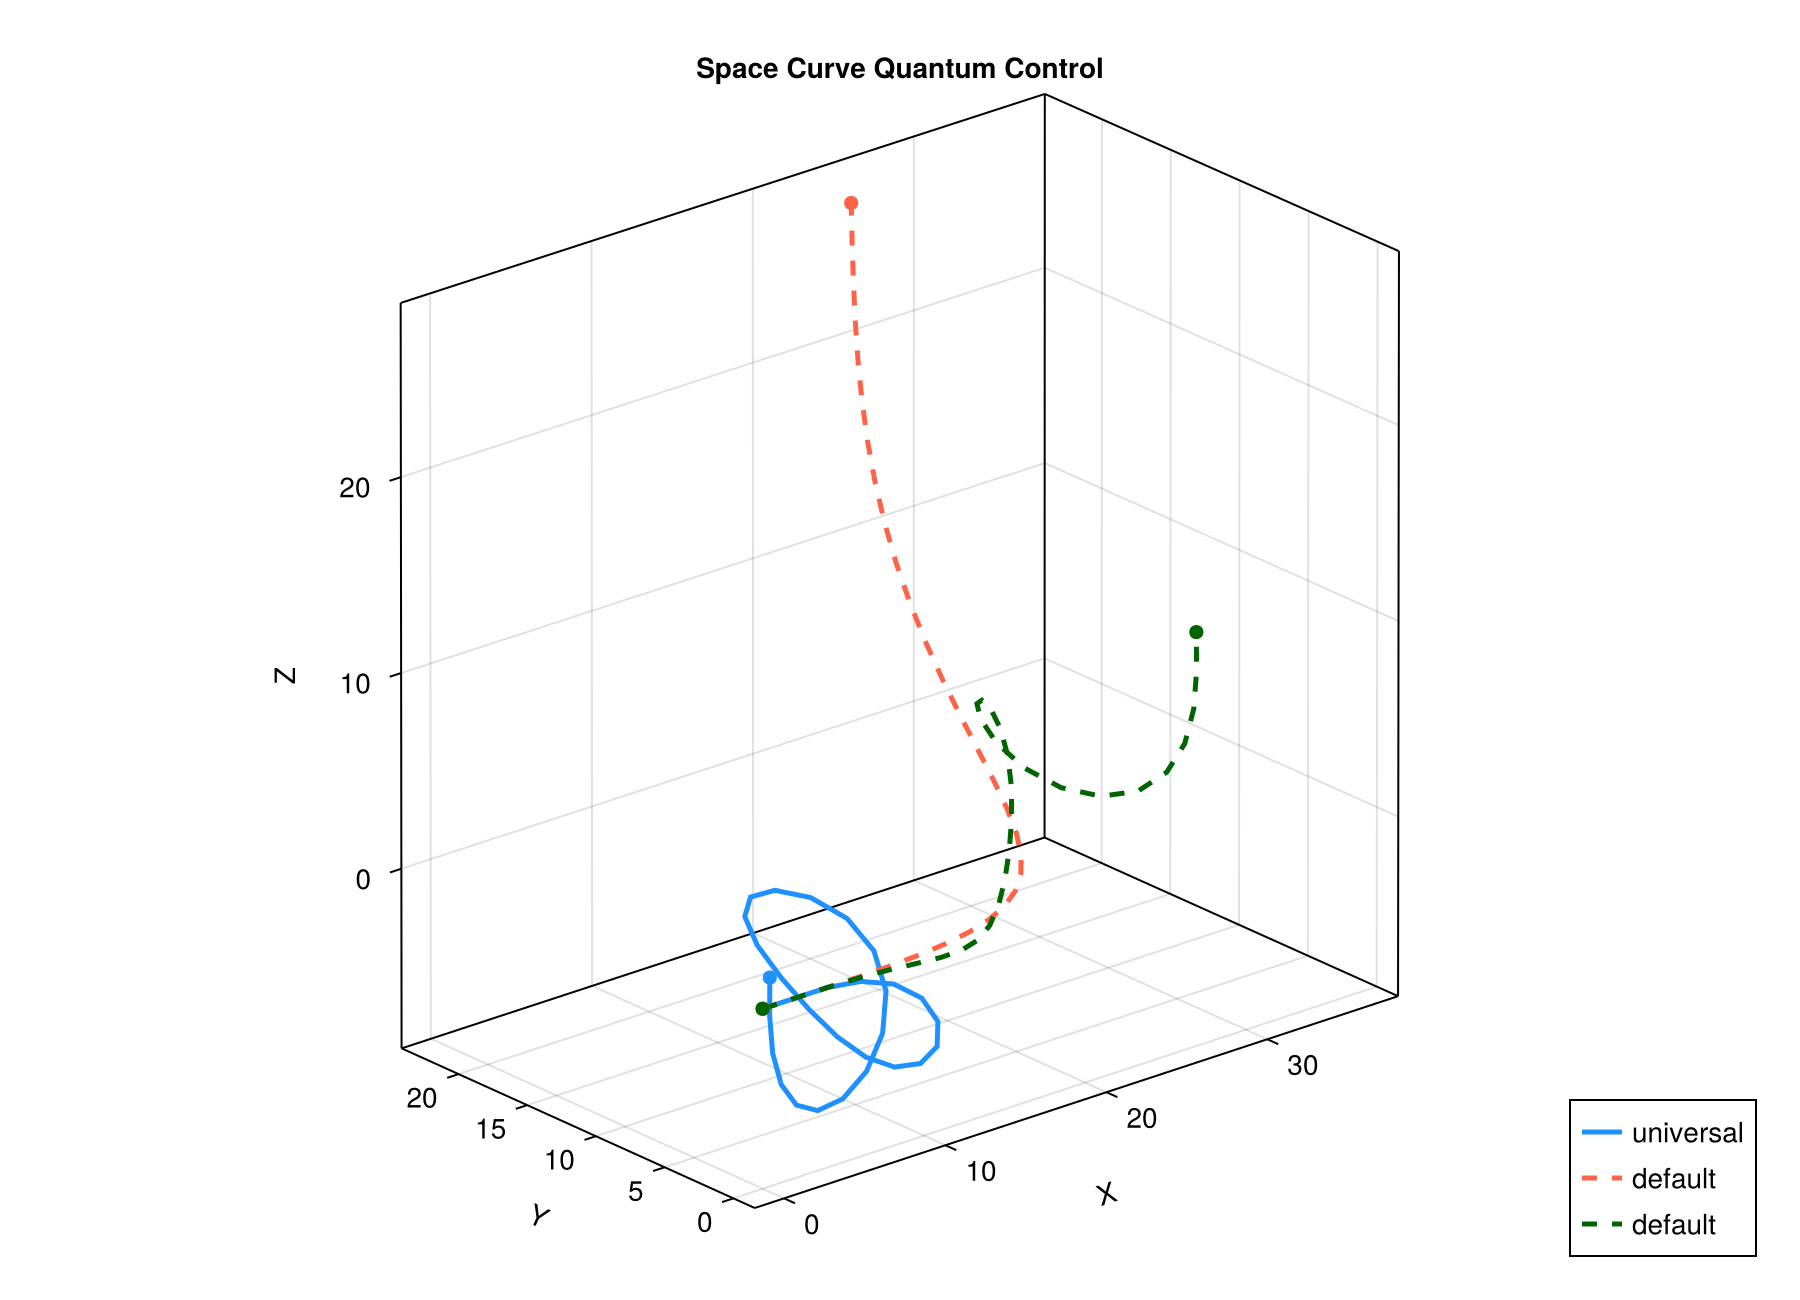

CairoMakie.Screen{IMAGE}


In [14]:
using CairoMakie
const CM = CairoMakie

function to_xyz(curve)
    if curve isa AbstractMatrix
        M = Float64.(real.(curve))
        if size(M, 2) == 3
            x, y, z = M[:, 1], M[:, 2], M[:, 3]
        elseif size(M, 1) == 3
            x, y, z = M[1, :], M[2, :], M[3, :]
        else
            error("Matrix curve must be T×3 or 3×T, got $(size(M))")
        end
    else
        x = Float64.(real.(getindex.(curve, 1)))
        y = Float64.(real.(getindex.(curve, 2)))
        z = Float64.(real.(getindex.(curve, 3)))
    end
    mask = isfinite.(x) .& isfinite.(y) .& isfinite.(z)
    return x[mask], y[mask], z[mask]
end

Hₑ = PAULIS.X

ftog_curve     = SpaceCurve(ftog_traj, U_goal, Hₑ)
var_curve     = SpaceCurve(var_traj, U_goal, Hₑ)
default_curve = SpaceCurve(default_traj, U_goal, Hₑ)

x3, y3, z3 = to_xyz(ftog_curve)
x1, y1, z1 = to_xyz(var_curve)
x2, y2, z2 = to_xyz(default_curve)

pushfirst!(x1, 0.0)
pushfirst!(y1, 0.0)
pushfirst!(z1, 0.0)
pushfirst!(x2, 0.0)
pushfirst!(y2, 0.0)
pushfirst!(z2, 0.0)
pushfirst!(x3, 0.0)
pushfirst!(y3, 0.0)
pushfirst!(z3, 0.0)

f  = CM.Figure(size = (900, 650))
ax = CM.Axis3(f[1, 1];
    xlabel = "X", ylabel = "Y", zlabel = "Z",
    title = "Space Curve Quantum Control", aspect = :data
)

CM.lines!(ax, x1, y1, z1; linewidth = 2.5, color = :dodgerblue, label = "universal")
CM.lines!(ax, x2, y2, z2; linewidth = 2.5, linestyle = :dash, color = :tomato, label = "default")
CM.lines!(ax, x3, y3, z3; linewidth = 2.5, linestyle = :dash, color = :darkgreen, label = "default")

CM.scatter!(ax, [x1[1]],  [y1[1]],  [z1[1]];  markersize = 10, color = :dodgerblue)
CM.scatter!(ax, [x1[end]],[y1[end]],[z1[end]]; markersize = 10, color = :dodgerblue)
CM.scatter!(ax, [x2[1]],  [y2[1]],  [z2[1]];  markersize = 10, color = :tomato)
CM.scatter!(ax, [x2[end]],[y2[end]],[z2[end]]; markersize = 10, color = :tomato)
CM.scatter!(ax, [x3[1]],  [y3[1]],  [z3[1]];  markersize = 10, color = :darkgreen)
CM.scatter!(ax, [x3[end]],[y3[end]],[z3[end]]; markersize = 10, color = :darkgreen)

CM.axislegend(ax; position = :rb)

display(f)

     

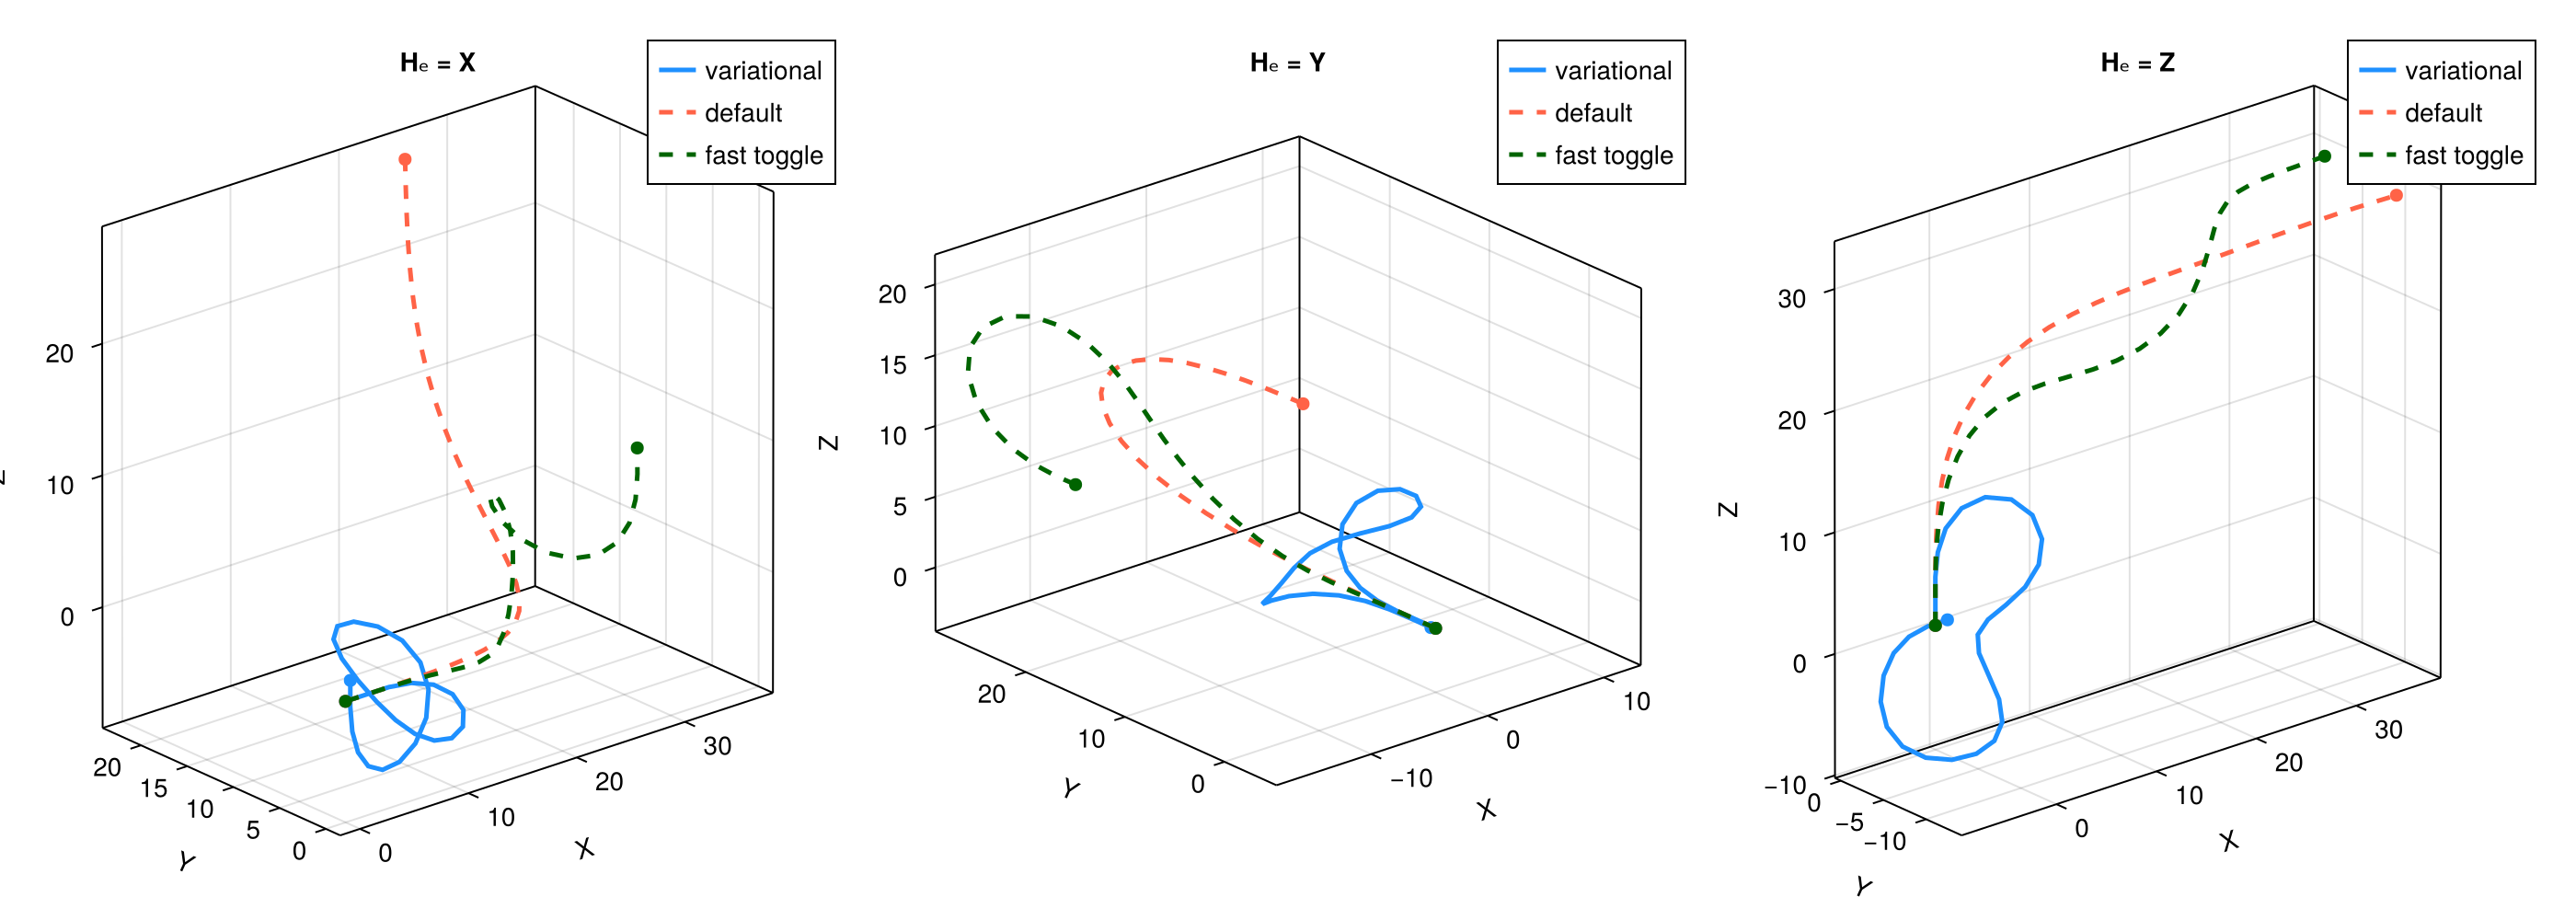

CairoMakie.Screen{IMAGE}


In [15]:
using CairoMakie
const CM = CairoMakie

# --- helpers ---------------------------------------------------------------

# Prepend the origin to each coordinate vector
prepend_origin!(xs...) = (foreach(v -> pushfirst!(v, 0.0), xs); nothing)

# Define CURVE_SPECS once, then mutate it on reruns to avoid the const redefinition warning
if !@isdefined CURVE_SPECS
    const CURVE_SPECS = NamedTuple{(:name,:traj,:linecolor,:linestyle,:startcolor,:endcolor)}[]
end
empty!(CURVE_SPECS)
append!(CURVE_SPECS, [
    (name = "variational",       traj = () -> var_traj,    linecolor = :dodgerblue,  linestyle = :solid, startcolor = :dodgerblue,  endcolor = :dodgerblue),
    (name = "default",         traj = () -> default_traj,linecolor = :tomato,      linestyle = :dash,  startcolor = :tomato,      endcolor = :tomato),
    (name = "fast toggle",  traj = () -> ftog_traj,  linecolor = :darkgreen, linestyle = :dash,  startcolor = :darkgreen, endcolor = :darkgreen),
    # (name = "toggle", traj = () -> tog_traj,  linecolor = :darkorchid4,      linestyle = :solid,  startcolor = :darkorchid4,      endcolor = :darkorchid4),
])

# Build SpaceCurve objects for a given Hₑ (also set the global Hₑ used elsewhere)
function curves_for(Hₑ_sym)
    global Hₑ = Hₑ_sym  # required because SpaceCurve (or other code) reads global Hₑ
    return [
        (label = spec.name,
         curve = SpaceCurve(spec.traj(), U_goal, Hₑ_sym),
         linecolor = spec.linecolor,
         linestyle = spec.linestyle,
         startcolor = spec.startcolor,
         endcolor   = spec.endcolor)
        for spec in CURVE_SPECS
    ]
end

# --- plotting --------------------------------------------------------------

function plot_pair!(pos, Hₑ_sym, ttl)
    ax = CM.Axis3(pos; xlabel = "X", ylabel = "Y", zlabel = "Z", title = ttl, aspect = :data)

    for spec in curves_for(Hₑ_sym)
        x, y, z = to_xyz(spec.curve)
        prepend_origin!(x, y, z)

        CM.lines!(ax, x, y, z; linewidth = 2.5, color = spec.linecolor, linestyle = spec.linestyle, label = spec.label)
        CM.scatter!(ax, [first(x)], [first(y)], [first(z)]; markersize = 10, color = spec.startcolor)
        CM.scatter!(ax, [last(x)],  [last(y)],  [last(z)];  markersize = 10, color = spec.endcolor)
    end

    CM.axislegend(ax; position = :rt)
    return ax
end

# --- figure ---------------------------------------------------------------

f = CM.Figure(size = (1400, 500))
for (i, (Hₑ, tag)) in enumerate(((PAULIS.X, "X"), (PAULIS.Y, "Y"), (PAULIS.Z, "Z")))
    plot_pair!(f[1, i], Hₑ, "Hₑ = $tag")
end
display(f)


In [16]:
ket_0 = [1.0,0.0]

rho_0 = ket_0 * ket_0'

expect_val_x = [real(tr(PAULIS.X * iso_vec_to_operator(var_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(var_traj.Ũ⃗[:, t])')) for t in 1:var_traj.T]
expect_val_y = [real(tr(PAULIS.Y * iso_vec_to_operator(var_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(var_traj.Ũ⃗[:, t])')) for t in 1:var_traj.T]
expect_val_z = [real(tr(PAULIS.Z * iso_vec_to_operator(var_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(var_traj.Ũ⃗[:, t])')) for t in 1:var_traj.T]
expect_val_x_1 = [real(tr(PAULIS.X * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]
expect_val_y_1 = [real(tr(PAULIS.Y * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]
expect_val_z_1 = [real(tr(PAULIS.Z * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]

     

30-element Vector{Float64}:
  1.0
  1.0
  0.9998995153805612
  0.9990986685147302
  0.9963760063177238
  0.9899282170229601
  0.9774963042514317
  0.9565712570670668
  0.9247686714029911
  0.8801407295307124
  ⋮
  0.07806989031362238
  0.06476304547854539
  0.0544743931575577
  0.04404646878892243
  0.031910424497410605
  0.02058409577433068
  0.01090941296186615
  0.003263094219981888
 -0.0010503804082926949

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/samafine1/.julia/packages/Makie/FUAHr/src/scenes.jl:238
┌ Warning: `shading = true` is not valid. Use `Makie.automatic`, `NoShading`, `FastShading` or `MultiLightShading`. Defaulting to `MakieCore.Automatic()`.
└ @ Makie /Users/samafine1/.julia/packages/Makie/FUAHr/src/lighting.jl:243


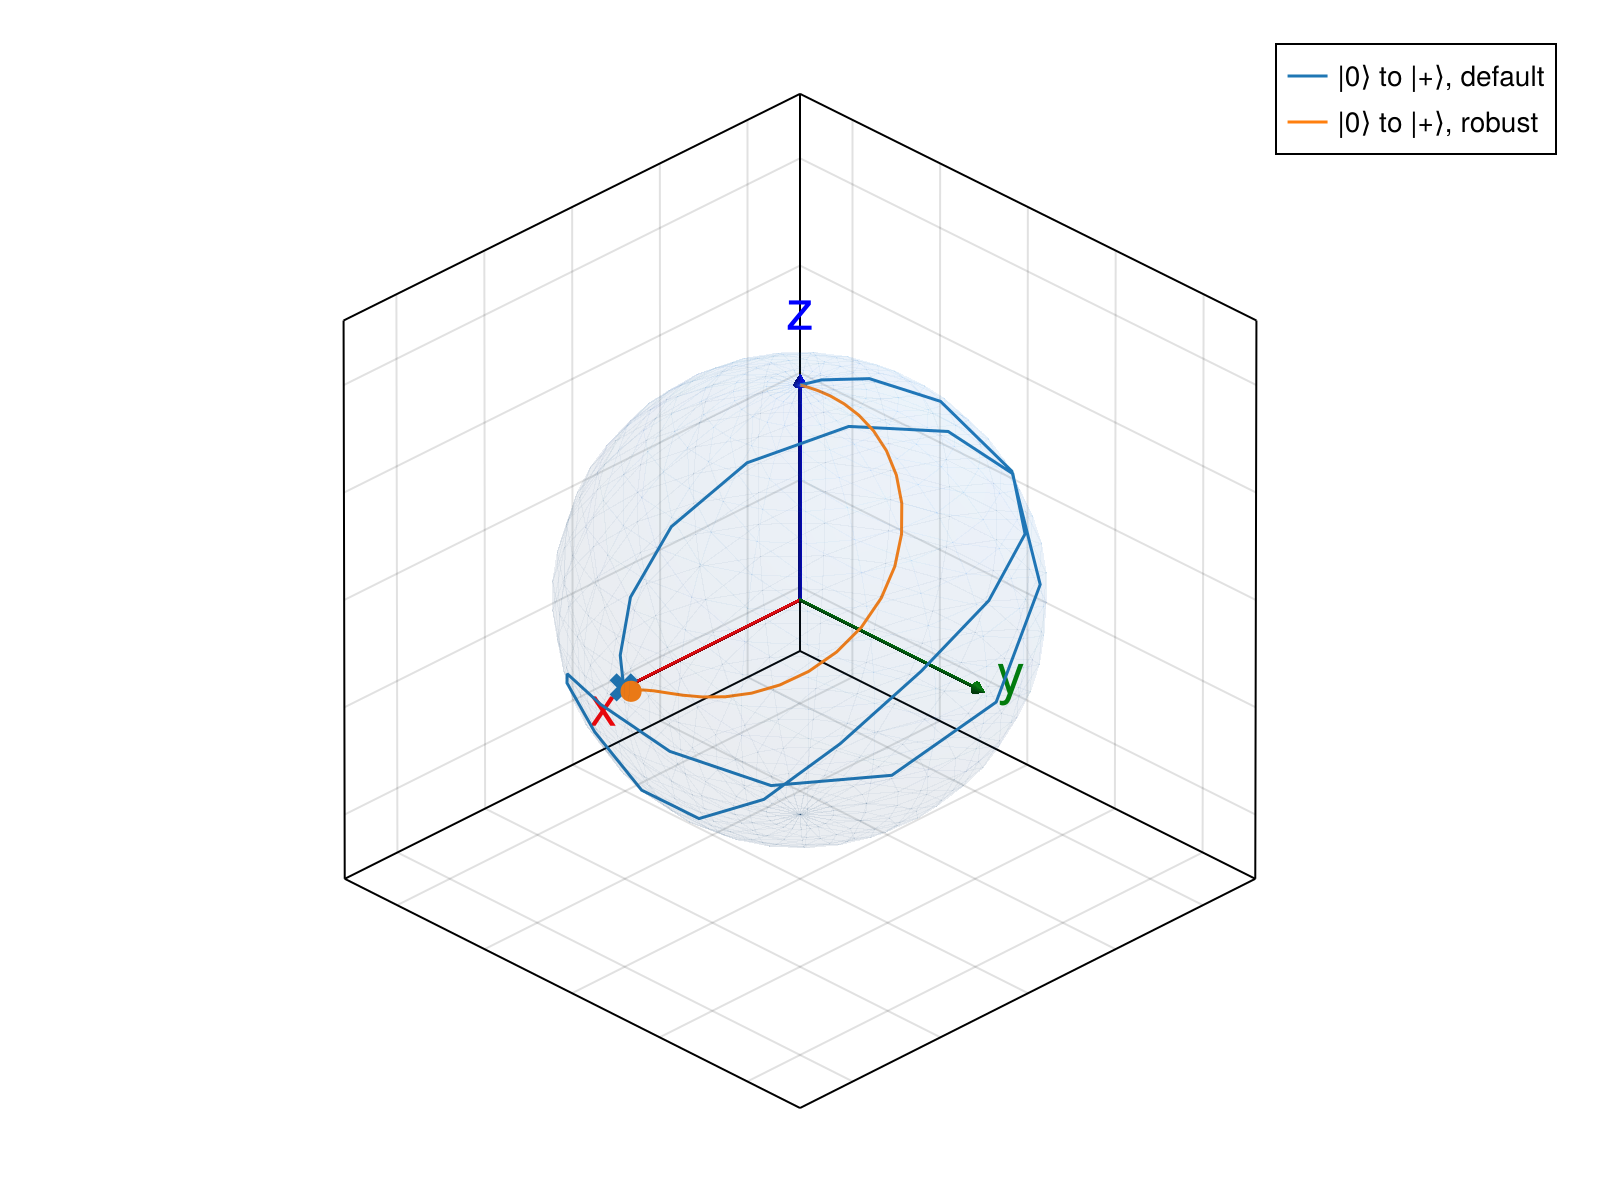

In [17]:
using CairoMakie
using GeometryBasics

f  = CairoMakie.Figure(resolution = (800, 600))
ax = CairoMakie.Axis3(f[1, 1];
    aspect = :equal
)

palette = to_colormap(:tab10)
styles  = (:solid, :dash, :dot, :dashdot)

origins = [Point3f(0,0,0), Point3f(0,0,0), Point3f(0,0,0)]
dirs    = [Vec3f(1.0,0,0), Vec3f(0,1.0,0), Vec3f(0,0,1.0)]

CairoMakie.arrows!(ax, origins, dirs;
    color = [:red, :green, :blue],
    arrowsize = 0.05,
    linewidth = 0.01
)

CairoMakie.text!(ax, "x", position = Point3f(1.2, 0, 0), align = (:left, :center),  color = :red,   fontsize = 28)
CairoMakie.text!(ax, "y", position = Point3f(0, 1.2, 0), align = (:center, :bottom), color = :green, fontsize = 28)
CairoMakie.text!(ax, "z", position = Point3f(0, 0, 1.2), align = (:center, :bottom), color = :blue,  fontsize = 28)

CairoMakie.lines!(ax, real.(expect_val_x), real.(expect_val_y), real.(expect_val_z);
    color     = palette[1],
    linestyle = styles[1],
    label     = "|0⟩ to |+⟩, default",
    linewidth = 1.5
)

CairoMakie.lines!(ax, real.(expect_val_x_1), real.(expect_val_y_1), real.(expect_val_z_1);
    color     = palette[2],
    linestyle = styles[1],
    label     = "|0⟩ to |+⟩, robust",
    linewidth = 1.5
)

CairoMakie.scatter!(ax, [real(expect_val_x[end])], [real(expect_val_y[end])], [real(expect_val_z[end])];
    color = palette[1], markersize = 20, marker = :xcross)

CairoMakie.scatter!(ax, [real(expect_val_x_1[end])], [real(expect_val_y_1[end])], [real(expect_val_z_1[end])];
    color = palette[2], markersize = 15, marker = :circle)

CairoMakie.mesh!(ax, Sphere(Point3f(0,0,0), 1f0);
    color = (0.2, 0.6, 1.0, 0.05),
    transparency = true,
    shading = true
)

CairoMakie.xlims!(ax, -1.3, 1.3)
CairoMakie.ylims!(ax, -1.3, 1.3)
CairoMakie.zlims!(ax, -1.3, 1.3)

ax.azimuth[]   =  π/4
ax.elevation[] =  π/6

CairoMakie.axislegend(ax; position = :rt)
CairoMakie.hidexdecorations!(ax, grid = false)
CairoMakie.hideydecorations!(ax, grid = false)
CairoMakie.hidezdecorations!(ax, grid = false)

f
     

check variational objective

In [18]:
function var_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}}, 
    H_errors::Vector{Matrix{ComplexF64}}
)
    Δt = traj.Δt[1]
    varsys = VariationalQuantumSystem(H_drives, H_errors)
    Ũ⃗, ∂Ũ⃗ = variational_unitary_rollout(traj, varsys)

    U = iso_vec_to_operator(Ũ⃗[:, end])
    # First error term
    ∂U = iso_vec_to_operator(∂Ũ⃗[1][:, end])

    d = size(U, 1)
    return abs(tr((U'*∂U)'*(U'*∂U))) / (T * Δt)^2 / d
end

var_obj (generic function with 1 method)

In [19]:
∂ₑH = [PAULIS.X, PAULIS.Y, PAULIS.Z]
H_drives = [PAULIS.X, PAULIS.Y, PAULIS.Z]
error_ops = [PAULIS.X, PAULIS.Y, PAULIS.Z]

J_var = var_obj(def.trajectory, H_drives, error_ops)

0.49806310218016164

In [20]:
J_var = var_obj(ftog_prob.trajectory, H_drives, error_ops)

0.3874868216154279

In [21]:
J_var = var_obj(var_prob.trajectory, H_drives, error_ops)

0.00011870079096326594